In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import *
# from scipy.ndimage import interpolation
import time

In [2]:
%%time
mnist = fetch_openml("mnist_784")

CPU times: user 17.4 s, sys: 351 ms, total: 17.8 s
Wall time: 17.8 s


In [3]:
mnist.data.shape

(70000, 784)

In [4]:
mnist.target.shape

(70000,)

In [5]:
images = mnist.data
targets = mnist.target
labels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
target_name = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [6]:
# def moments(image):
#     c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
#     totalImage = np.sum(image) #sum of pixels
#     m0 = np.sum(c0*image)/totalImage #mu_x
#     m1 = np.sum(c1*image)/totalImage #mu_y
#     m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
#     m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
#     m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
#     mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
#     covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
#     return mu_vector, covariance_matrix

# def deskew(image):
#     c,v = moments(image)
#     alpha = v[0,1]/v[0,0]
#     affine = np.array([[1,0],[alpha,1]])
#     ocenter = np.array(image.shape)/2.0
#     offset = c-np.dot(affine,ocenter)
#     img = interpolation.affine_transform(image,affine,offset=offset)
#     return (img - img.min()) / (img.max() - img.min())

In [7]:
# deskewed=[deskew(img) for img in trT[1]]
# deskewedTr=np.array(deskewed)
# print(deskewedTr.shape)

In [8]:
# stratify sampling
def sampling(X, y, test_size=0.3, do_stratify=True):
    if do_stratify:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=123, stratify=y)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=123, stratify=None)
    
    # scaler
    scaler = StandardScaler() # mean: 0, std: 1
    # scaler = MinMaxScaler() # max: 1, min: 0
    # scaler = RobustScaler() # median : 0, IQR : 1
    scaler.fit(X_train)
    
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [9]:
def count_target(target):
    for i in range(10):
        unique, counts = np.unique(target, return_counts=True)
        
    return counts

# SVM - linear kernel

In [10]:
# C = [1000.0, 100.0, 10.0, 1.0, 0.1, 0.01, 0.001]

In [27]:
def run_gridsearchcv(X_train, y_train, C):
    """
    SVC : C-Support Vector Classification.
    GridSearchCV : Exhaustive search over specified parameter values for an estimator
                   estimator : SVM Classifier
                   parameters : linear kernel, C
                   scoring : f1
                   cross-validation : 10 times
    """
    
    parameters = {'kernel':['linear'], 'C':C}
    
    svc = SVC()
    clf = GridSearchCV(estimator=svc, param_grid=parameters, scoring='f1_micro', cv=10, n_jobs=-1)
    print(clf, "\n")
    # training

    start_time = time.time()
    %time clf.fit(X_train, y_train)
    end_time = time.time()
#     scores_df = pd.DataFrame(clf.cv_results_)
    best_param = clf.best_params_
    best_score = clf.best_score_
    
    print("training time : ", end_time-start_time, "\n")
    print("cv results : \n", clf.cv_results_, "\n")
#     print("cv_validation_scores : \n", clf.cv_results_["cv_validation_scores"]) # every result of cross-validation
#     print("mean_test_score : \n", clf.cv_results_["mean_test_score"]) # mean of result of cross-validation
    print("scorer : ", clf.scorer_)
    print("best\n", best_param, " : ", best_score)
#     scores_df[sorted(clf.cv_results_.keys())]
    
#     with open("./results/train.txt", "a") as f:
#         data = "training time : " + str(end_time-start_time) + "\n"
#         data += "cv_validation_scores\n" + "="*10 + "n" + str(clf.cv_results_["cv_validation_scores"]) + "\n"
#         data += "mean_test_score\n" + "="*10 + "n" + str(clf.cv_results_["mean_test_score"]) + "\n"
#         data += "\nbest_param : " + str(best_param) + "\tbest_score : " + str(best_score)
#         f.write(data)

    return best_param, clf.cv_results_

In [12]:
def diff_run_time(X_train, y_train, C):
    for c in C:
        print("C is %f" %c)

        start_time = time.time()
        %time clf = SVC(kernel="linear", C=c).fix(X_train, y_train)
        end_time = time.time()
        print("running time : ", end_time - start_time)
    
#     with open("./results/diff_run_time.txt", "a") as f:
#         data = "C is" + str(C) + "\nrunning time : " + str(end_time-start_time) + "\n"
#         f.write(data)

In [28]:
def test(X_train, X_test, y_train, y_test, C, target_name):
    clf = SVC(kernel="linear", C=C).fit(X_train, y_train)
    %time y_pred = clf.predict(X_test)
    
    cv_report = classification_report(y_test, y_pred, target_name=target_name)
    print("cv_report\n", cv_report)
    
    res_SVM = []
    res_SVM.append([accuracy_score(y_test, y_pred),
              precision_score(y_test, y_pred, average="micro"),
              recall_score(y_test, y_pred, average="micro"),
              f1_score(y_test, y_pred, average="micro")])
    
    # scores
    res_pd = pd.DataFrame(res_SVM, columns = ["Accuracy", "Precision", "Recall", "F1-score"], index=["SVM"])
    print(res_pd)
    
    # confusion matrix
    cmat = confusion_matrix(y_test, y_pred, target_name)
    sns.set_palette("husl")
    plt.figure(figsize=(12,6))
    sns.heatmap(cmat, annot=True)
    
    # TODO : ROC curve
    
#     with open("./results/test_cv_report.txt", "a") as f:
#         data = "classification report : \n" + str(cv_report)
#         data += str(res_SVM[i] for i in range(4))
#         f.write(data)

In [14]:
X_train, X_test, y_train, y_test = sampling(images, targets, 0.3, True)

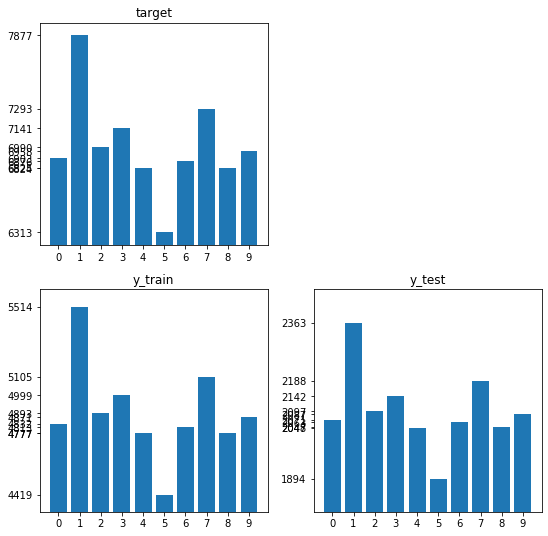

In [15]:
# distribution of numbers after stratify sampling
count_y_train = count_target(y_train)
count_y_test = count_target(y_test)
count_y = count_target(targets)

plt.figure(figsize=(9,9))

plt.subplot(221)
plt.bar(labels, count_y)
plt.title("target")
plt.xticks(labels, labels)
plt.yticks(count_y)
plt.ylim(min(count_y)-100, max(count_y)+100)

plt.subplot(223)
plt.bar(labels, count_y_train)
plt.title("y_train")
plt.xticks(labels, labels)
plt.yticks(count_y_train)
plt.ylim(min(count_y_train)-100, max(count_y_train)+100)

plt.subplot(224)
plt.bar(labels, count_y_test)
plt.title("y_test")
plt.xticks(labels, labels)
plt.yticks(count_y_test)
plt.ylim(min(count_y_test)-100, max(count_y_test)+100)

plt.show()

In [16]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(49000, 784) (21000, 784)
(49000,) (21000,)


In [17]:
# diff_run_time(X_train, y_train, C=[1000.0, 1.0, 0.001])

In [29]:
%%time
param, cv_results = run_gridsearchcv(X_train, y_train, C=[10.0, 1.0, 0.1, 0.01, 0.001])

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [10.0, 1.0, 0.1, 0.01, 0.001],
                         'kernel': ['linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_micro', verbose=0) 

CPU times: user 2min 42s, sys: 384 ms, total: 2min 42s
Wall time: 50min 6s
training time :  3006.00284576416 

cv results : 
 {'mean_fit_time': array([1409.70832818,  604.74459655,  565.83499832,  586.89758658,
        706.79060931]), 'std_fit_time': array([163.24712355,  41.47027399,  53.62983841,  16.16435831,
    

In [30]:
%%time
param_100, cv_results_100 = run_gridsearchcv(X_train, y_train, C=[100.0])

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100.0], 'kernel': ['linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_micro', verbose=0) 

CPU times: user 1h 57min 38s, sys: 554 ms, total: 1h 57min 38s
Wall time: 3h 35min 6s
training time :  12906.865638494492 

cv results : 
 {'mean_fit_time': array([5169.55596304]), 'std_fit_time': array([451.9247594]), 'mean_score_time': array([25.8997998]), 'std_score_time': array([2.9108412]), 'param_C': masked_array(data=[100.0],
             mask=[False],
   

In [19]:
param

{'C': 0.01, 'kernel': 'linear'}

In [20]:
# DO NOT UNCOMMENT!!
# test(X_train, X_test, y_train, y_test, param, target_name)